In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [13]:
DIRECTORY=r"C:\Users\harsh\Downloads\Face-Mask-Detection-master\dataset"
CATEGORIES=['with_mask','without_mask']

In [14]:
data=[]
labels=[]

for categories in CATEGORIES:
    path=os.path.join(DIRECTORY, categories)
    for img in os.listdir(path):
        img_path=os.path.join(path,img)
        image=load_img(img_path,target_size=(224,224))
        image=img_to_array(image)
        image=preprocess_input(image)
        
        data.append(image)
        labels.append(categories)

C:\Users\harsh\anaconda3\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [15]:
#one hot encoding
lb = LabelBinarizer()
labels=lb.fit_transform(labels)
labels = to_categorical(labels)

In [17]:
#stacking the data in  NUMPY ARRAYS 
data=np.array(data, dtype=float)
labels=np.array(labels)

In [19]:
# spliiting in train and test data 
train_X,test_X,train_Y,test_Y=train_test_split(data,labels,test_size=.2 , stratify =labels , random_state=112)

In [20]:
aug = ImageDataGenerator(
    rotation_range=21,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest')

In [26]:
#mobilenet base layer
baseModel=MobileNetV2(weights="imagenet",include_top=False,input_tensor=Input(shape=(224,224,3)))

#Now creating the head of the model and conneting the base model with it 
headModel=baseModel.output
headModel=AveragePooling2D(pool_size=(7,7))(headModel)
headModel=Flatten(name="flatten")(headModel)
headModel=Dense(128,activation='relu')(headModel)
headModel=Dropout(0.5)(headModel) #to avoid overfitting of the model
headModel=Dense(2,activation="softmax")(headModel)

#putting the head model on top of base model
model=Model(inputs=baseModel.input,outputs=headModel)

#loop over all layer of base model and freeze them 
for layer in baseModel.layers:
    layer.trainable =False

#compiling the model 
print("compiling head....")


compiling head....


In [28]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

In [29]:
print("training head")
H = model.fit(
    aug.flow(train_X,train_Y,batch_size=32),
    steps_per_epoch=len(train_X) // BS,
    validation_data=(test_X,test_Y),
    validation_steps=len(test_X) // BS,
    epochs=EPOCHS
    )

training head
Epoch 1/20
95/95 [==============================] - 84s 834ms/step - loss: 0.5948 - accuracy: 0.7208 - val_loss: 0.1743 - val_accuracy: 0.9648
Epoch 2/20
95/95 [==============================] - 76s 796ms/step - loss: 0.1819 - accuracy: 0.9576 - val_loss: 0.0995 - val_accuracy: 0.9739
Epoch 3/20
95/95 [==============================] - 83s 868ms/step - loss: 0.1002 - accuracy: 0.9784 - val_loss: 0.0770 - val_accuracy: 0.9765
Epoch 4/20
95/95 [==============================] - 82s 858ms/step - loss: 0.0834 - accuracy: 0.9792 - val_loss: 0.0651 - val_accuracy: 0.9791
Epoch 5/20
95/95 [==============================] - 81s 854ms/step - loss: 0.0647 - accuracy: 0.9807 - val_loss: 0.0557 - val_accuracy: 0.9804
Epoch 6/20
95/95 [==============================] - 88s 928ms/step - loss: 0.0680 - accuracy: 0.9807 - val_loss: 0.0583 - val_accuracy: 0.9791
Epoch 7/20
95/95 [==============================] - 88s 931ms/step - loss: 0.0481 - accuracy: 0.9857 - val_loss: 0.0512 - val_ac

In [30]:
predIdxs=model.predict(test_X,batch_size=BS)
predIdxs=np.argmax(predIdxs,axis=1)


In [33]:
print(classification_report(test_Y.argmax(axis=1),predIdxs,target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.97      0.99      0.98       383
without_mask       0.99      0.97      0.98       384

    accuracy                           0.98       767
   macro avg       0.98      0.98      0.98       767
weighted avg       0.98      0.98      0.98       767



In [34]:
model.save("mask_detector.model",save_format="h5")

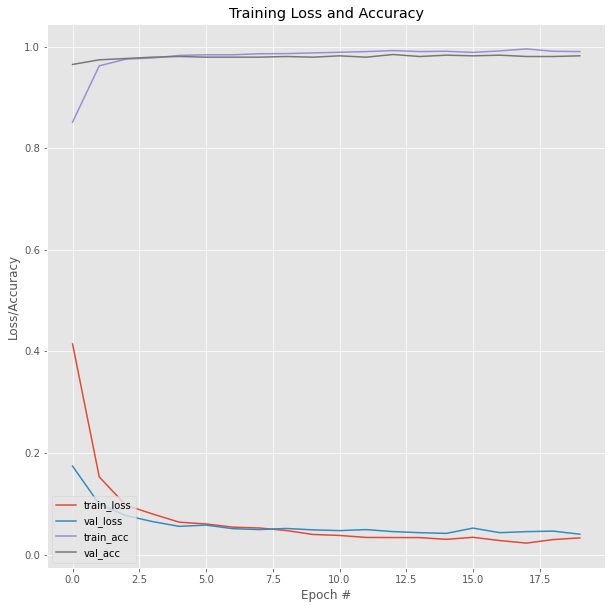

In [39]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure(figsize=(10,10))
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")